In [27]:
import pandas as pd

In [28]:
import numpy as np
from io import open
%matplotlib inline
import Levenshtein
import seaborn as sns
import pylab as pl

from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error


## Generic Helper Functions 

In [29]:
def get_num_syllables(v):
    vowels=set(['AA','AE','AH','AO','AW','AY','EH','ER','EY','IH','IY','OW','OY','UH','UW'])
    phonemes=v.split(' ')
    cv=0
    for p in phonemes:
        if p in vowels:
            cv=cv+1
    return cv

In [30]:
def clip_helper(v, num_syllables=2, ctype='BACK'):
    vowels=set(['AA','AE','AH','AO','AW','AY','EH','ER','EY','IH','IY','OW','OY','UH','UW'])
    phonemes=v.split(' ')        
    cv=0
    output=[]
    if ctype=='BACK':
        for p in phonemes:
            if p in vowels:
                cv=cv+1
                if cv > num_syllables:
                    break
            output.append(p)
    elif ctype == 'FORE':
        phonemes_v=' '.join(phonemes[::-1])
        cp = clip_helper(phonemes_v, num_syllables, ctype='BACK')
        output = cp.split(' ')[::-1]
    return ' '.join(output)

In [49]:
def clip(v, num_syllables=2):
    vowels=set(['AA','AE','AH','AO','AW','AY','EH','ER','EY','IH','IY','OW','OY','UH','UW'])
    phonemes=v.split(' ')
    ctype=global_pmf.sample()
    if '@' in v: # compound clippins
        part1=v.split('@')[0]
        part2=v.split('@')[1]
        part1_phonemes = part1.strip().split(' ')
        part2_phonemes = part2.strip().split(' ')
        part1_clip=clip_helper(' '.join(part1_phonemes), num_syllables=1)
        part2_clip=clip_helper(' '.join(part2_phonemes), num_syllables=1)
        assert '@' not in part1_clip
        assert '@' not in part2_clip
        return part1_clip + ' ' + part2_clip
    else:
        return clip_helper(v, num_syllables, ctype=ctype)


In [32]:
def pred_num_syllables_clipping(v):
    return int(ml.predict(v)[0])

In [33]:
def random_clip(v, num_syllables=2):
    vowels=set(['AA','AE','AH','AO','AW','AY','EH','ER','EY','IH','IY','OW','OY','UH','UW'])
    v=v.replace('@',' ')
    phonemes=v.split(' ')
    keep_length=np.random.randint(1, len(v)+1)
    return ' '.join(phonemes[:keep_length])

In [34]:
from collections import Counter
class Pmf(Counter):
    """A Counter with probabilities."""

    def normalize(self):
        """Normalizes the PMF so the probabilities add to 1."""
        total = float(sum(self.values()))
        for key in self:
            self[key] /= total

    def __add__(self, other):
        """Adds two distributions.

        The result is the distribution of sums of values from the
        two distributions.

        other: Pmf

        returns: new Pmf
        """
        pmf = Pmf()
        for key1, prob1 in self.items():
            for key2, prob2 in other.items():
                pmf[key1 + key2] += prob1 * prob2
        return pmf

    def __hash__(self):
        """Returns an integer hash value."""
        return id(self)
    
    def __eq__(self, other):
        return self is other

    def render(self):
        """Returns values and their probabilities, suitable for plotting."""
        return zip(*sorted(self.items()))
    
    def sample(self):
        keys, vals= zip(*self.items())
        return np.random.choice(keys, p=vals)

In [35]:
def get_num_phonemes(p):
    return len(p.replace('@',' ').split(' '))

In [36]:
def get_global_syll_score(row):
    if '@' in row.word:
        return row.tedit
    if row.pred_num_syll==1:
        return row.oedit
    else:
        return row.tedit

In [37]:
def get_edit_distances_grapheme(row):
    return Levenshtein.distance(row.clipping, row.goldgrapheme), Levenshtein.distance(row.clipping, row.rand), Levenshtein.distance(row.clipping, row.one), Levenshtein.distance(row.clipping, row.two)

In [38]:
orecs=[]
f = open('./data/clippings_analysis.txt')
for l in f:
    tokens=l.strip().split(' ')
    orecs.append((tokens[0], u' '.join(tokens[1:]).strip()))
df=pd.DataFrame().from_records(orecs, columns=['clipping','full'])
df_clipping_only=pd.read_csv('./data/only_clippings_gold.phonemes', sep='\t', skiprows=3, header=None, names=['word','phonemes'])
df_clipping_only["num"]=[get_num_syllables(ps) for ps in df_clipping_only.phonemes.values] 

In [39]:
df_components_only=pd.read_csv('./data/only_clippings_full_components_gold.phonemes', sep='\t', skiprows=3, header=None, names=['word','phonemes'])
df_components_only["num"]=[get_num_syllables(ps) for ps in df_components_only.phonemes.values] 
global_pmf=Pmf(Counter({'BACK':305,'FORE':83,'COMPOUND':0}))
global_pmf.normalize()
df_components_only["comp_phonemes_len"]=df_components_only.phonemes.apply(get_num_phonemes)
df_clipping_only["clipping_phonemes_len"]=df_clipping_only.phonemes.apply(get_num_phonemes)
syllable_counter_clippings=Counter(df_clipping_only.num.values)
syllable_counter_clippings_pmf = Pmf(syllable_counter_clippings)
syllable_counter_clippings_pmf.normalize()

## Read the outputs of Random, 1-Syllable, 2-Syllable and Gold Oracle

In [40]:
gold_clippings=df_clipping_only.word.values
gold_graphemes=[line.strip() for line in open('./data/gold_clipping_for_p2g_new.graphemes').readlines()]
rand_graphemes=[line.strip() for line in open('./data/rand_clipping_for_p2g_new.graphemes').readlines()]
one_syl_graphemes=[line.strip() for line in open('./data/one_syl_clipping_for_p2g_new.graphemes').readlines()]
two_syl_graphemes=[line.strip() for line in open('./data/two_syl_clipping_for_p2g_new.graphemes').readlines()]

edf_recs=zip(df_components_only.word.values, gold_clippings, gold_graphemes, rand_graphemes, one_syl_graphemes, two_syl_graphemes)
edf=pd.DataFrame().from_records(edf_recs, columns=['word','clipping','goldgrapheme','rand','one','two'])
edf=edf.astype(unicode)

edf["gedit"], edf["redit"], edf["oedit"], edf["tedit"]= zip(*edf.apply(get_edit_distances_grapheme, axis=1))

In [41]:
pred_num_syll = [syllable_counter_clippings_pmf.sample() for i in np.arange(0, len(edf))]
edf['min']=edf[['oedit','tedit']].min(axis=1)
edf["pred_num_syll"]=pred_num_syll
edf["gscore"]=edf.apply(get_global_syll_score, axis=1)

# Train the Length model (ClipGraph)

In [42]:
def clip_length(v):
    parts = v.split(' ')
    if len(parts) > 1:
        l=int(gm.predict(len(v))[0])
        return parts[0][:(l/2)] + parts[1][:l/2]
    else:
        ctype=global_pmf.sample()
        l=int(gm.predict(len(v))[0])
        if ctype == 'BACK':
            return v[:l]
        elif ctype == 'FORE':
            return v[-l:]

def get_edit_distance_clip_length(row):
    return Levenshtein.distance(row.clipping, row.cpleng)

In [43]:
mylengthdf=pd.DataFrame().from_records(zip(df_components_only.word.values,df_clipping_only.word, df_components_only.comp_phonemes_len.values, 
df_clipping_only.clipping_phonemes_len.values, df_clipping_only.num, df_components_only.num.values), columns=['word','clipping','comp_phonemes_len','clipping_phonemes_len', 'num', 'compnum'])
mylengthdf["wlen"]=mylengthdf.word.apply(len)

In [44]:
from sklearn.cross_validation import train_test_split
mylengthdf_train, mylengthdf_test= train_test_split(mylengthdf, train_size=0.7)
x=mylengthdf_train[["wlen"]].values
y=mylengthdf_train["num"].values

In [45]:
x_g=mylengthdf_train.word.apply(len).values
y_g=mylengthdf_train.clipping.apply(len).values
gm = BayesianRidge(verbose=True, compute_score=True, tol=0.0001)
gm.fit(x_g.reshape(-1,1),y_g)
edf["cpleng"]=edf.word.apply(clip_length)
edf["cpeditg"]=edf.apply(get_edit_distance_clip_length, axis=1)

Convergence after  2  iterations


# Plot the evaluation

In [46]:
edfm=edf[edf.word.isin(mylengthdf_test.word.values)]

In [47]:
import itertools
gredrecs=zip(itertools.repeat('gedit', len(edfm)), edfm.gedit.values)
rredrecs=zip(itertools.repeat('redit', len(edfm)), edfm.redit.values)
oredrecs=zip(itertools.repeat('oedit', len(edfm)), edfm.oedit.values)
tredrecs=zip(itertools.repeat('tedit', len(edfm)), edfm.tedit.values)
credrecs=zip(itertools.repeat('gscore', len(edfm)), edfm.gscore.values)
credrecsg=zip(itertools.repeat('cpeditg', len(edfm)), edfm.cpeditg.values)
cminrecs=zip(itertools.repeat('cminrecs', len(edfm)), edfm["min"].values)
vdf=pd.DataFrame().from_records(gredrecs+rredrecs+oredrecs+tredrecs+credrecs+credrecsg+cminrecs, columns=['model','distance'])

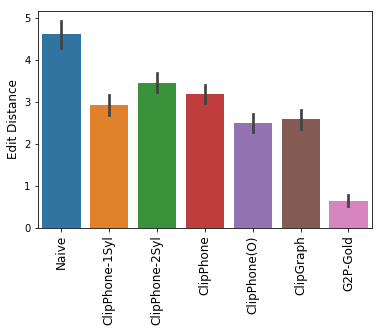

In [48]:
ax=sns.barplot(vdf.model, vdf.distance, order=['redit','oedit','tedit','gscore','cminrecs','cpeditg','gedit'])
ax.set_xticklabels(['Naive','ClipPhone-1Syl','ClipPhone-2Syl','ClipPhone','ClipPhone(O)', 'ClipGraph','G2P-Gold'], fontsize=12, rotation=90)
ax.set_xlabel('')
ax.set_ylabel('Edit Distance', fontsize=12)
pl.savefig('./figs/clipping_edit_distance_all.pdf', bbox_inches='tight')